In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_MultiShapeCirclesTranslation as model

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,0.])
o2 = torch.tensor([10.,0.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[10., 0.], [0, 5.]]
target = mm.multipleCircles(origin_target, radius, nb_pts)

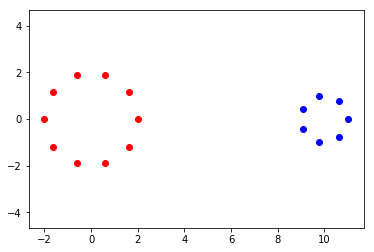

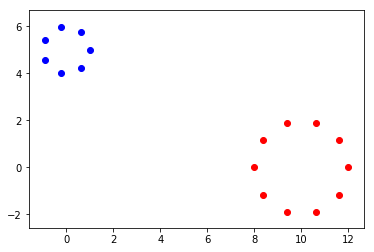

In [3]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 20
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

sigma2 = 20
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
#trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

module_list = [trans1, trans2]
sigma_bg = 1.
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [5]:
constr_Id = dm.constraints.Identity()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [6]:
gd0_list = [*source, source]
mom0_list = [*[torch.zeros(gd.shape) for gd in modules.manifold.gd[:-1]], [torch.zeros(gd.shape) for gd in modules.manifold.gd[-1]]]

In [7]:
# compound
#gd0_list = [[source[0].view(-1), source[1].view(-1)], source[1].view(-1), [source[0].view(-1), source[1].view(-1)], source[1].view(-1)]
#mom0_list = [*[[torch.rand(x.shape) for x in man.unroll_gd()] for man in modules.manifold.manifold_list[:-1]], [[torch.rand(x.shape) for x in man.unroll_gd()] for man in modules.manifold.manifold_list[-1]]]

#H.module.manifold.fill_gd([gd0_list[0], gd0_list[1], [gd0_list[2][0], gd0_list[2][1]]])
#H.module.manifold.fill_cotan([mom0_list[0], mom0_list[1], [mom0_list[2][0], mom0_list[2][1]]])
#H.geodesic_controls()

In [8]:
H.module.manifold.fill_gd([gd0_list[0].view(-1), gd0_list[1].view(-1), [gd0_list[2][0].view(-1), gd0_list[2][1].view(-1)]])
H.module.manifold.fill_cotan([mom0_list[0].view(-1), mom0_list[1].view(-1), [mom0_list[2][0].view(-1), mom0_list[2][1].view(-1)]])
H.geodesic_controls()

In [9]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat([gd0_list[0], gd0_list[1], gd0_list[2][0], gd0_list[2][1]],0).requires_grad_().view(-1)
mom0_tensor = torch.cat([mom0_list[0], mom0_list[1], mom0_list[2][0], mom0_list[2][1]],0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, target, dim, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

cost: 0.0 attach: 122.40635103436375
 iter : 0  ,total energy: 122.40635103436375
cost: 0.0 attach: 122.40635103436375
cost: 0.00127984384805 attach: 116.10935804540912
cost: 0.00287964863416 attach: 112.96086155627735
cost: 0.00647920617171 attach: 108.23811712855041
cost: 0.014577266567 attach: 101.15404626478639
cost: 0.0325257160582 attach: 90.53804890907443
cost: 0.0537821814737 attach: 76.50923464808511
cost: 0.0156337978448 attach: 71.10438924556838
cost: 0.0505167569571 attach: 67.64093583603783
cost: 0.181709084994 attach: 66.02354921635519
cost: 1.34845735749 attach: 71.40003904140795
cost: 14.932149565 attach: 482.2965209806043
cost: 0.0909557110906 attach: 67.85999022069524
cost: 0.142234428831 attach: 76.08798082085045
cost: 429.374607003 attach: 2608.251661272312
cost: 0.84855202397 attach: 67.66449869275277
cost: 869.768252435 attach: 3194.552882129546
cost: 0.245576714883 attach: 65.14546147994578
cost: 0.0952483627658 attach: 71.62434706461055
cost: 28.5077341367 attac

In [11]:
X = model.gradientdescent(EnergyFunctional, X)

cost: 0.638487719234 attach: 46.33476107551289
 iter : 0  ,total energy: 46.973248794747214
cost: 0.638487719234 attach: 46.33476107551289
cost: 0.578525940688 attach: 30.65235209726731
cost: 0.598015610202 attach: 29.615560017908685
cost: 1337.19704173 attach: 42.055914196336445
cost: 0.574917124962 attach: 29.74676238559918
cost: 0.732093000383 attach: 32.25907038741238
cost: 0.209866442828 attach: 57.628367634919556
cost: 0.573876979138 attach: 29.178514180157386
cost: 4.79253546007 attach: 109.38940574313881
cost: 0.580362109042 attach: 31.117055767339995
cost: 0.583312400724 attach: 29.237337270419836
cost: 156230.101345 attach: 7061.5505846295355
cost: 0.576368327959 attach: 30.116994954356468
cost: 0.643000885176 attach: 30.643836548743952
cost: 0.186722358345 attach: 53.87339588105087
cost: 0.573763581235 attach: 29.374495039740644
cost: 1.15307798178 attach: 53.21944916790575
cost: 0.58223662151 attach: 31.606129979522784
cost: 0.576711722023 attach: 29.104733456768567
cost: 5

In [12]:
optimized_mom = EnergyFunctional.tensor2list(X[1])

In [13]:
H.module.manifold.fill_gd(EnergyFunctional.tensor2list(X[0]))
H.module.manifold.fill_cotan(EnergyFunctional.tensor2list(X[1]))

states, controls = dm.shooting.shoot_euler(H, it=10)


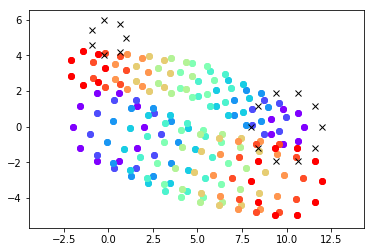

In [14]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.scatter(s.gd[0].view(-1,2)[:, 0].detach().numpy(), s.gd[0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[1].view(-1,2)[:, 0].detach().numpy(), s.gd[1].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][0].view(-1,2)[:, 0].detach().numpy(), s.gd[2][0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][1].view(-1,2)[:, 0].detach().numpy(), s.gd[2][1].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    
plt.axis('equal')
plt.show()

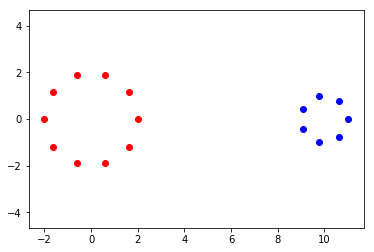

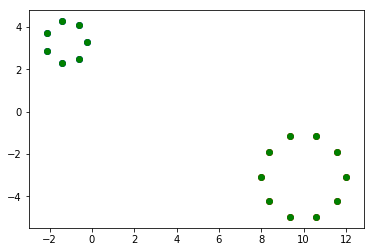

In [15]:
plt.figure()
plt.scatter(gd0_list[0].view(-1,2)[:, 0].detach().numpy(), gd0_list[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd0_list[1].view(-1,2)[:, 0].detach().numpy(), gd0_list[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')


gd_moved = EnergyFunctional.h.module.manifold.gd

plt.figure()
plt.scatter(gd_moved[0].view(-1,2)[:, 0].detach().numpy(), gd_moved[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_moved[1].view(-1,2)[:, 0].detach().numpy(), gd_moved[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.scatter(gd_moved[2][0].view(-1,2)[:, 0].detach().numpy(), gd_moved[2][0].view(-1,2)[:, 1].detach().numpy(), c='green')

plt.scatter(gd_moved[2][1].view(-1,2)[:, 0].detach().numpy(), gd_moved[2][1].view(-1,2)[:, 1].detach().numpy(), c='green')

plt.axis('equal')

plt.show()

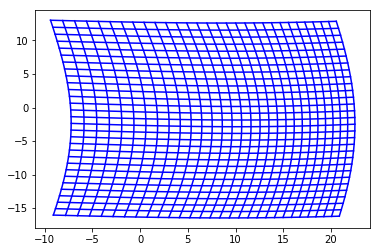

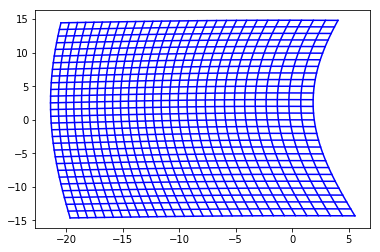

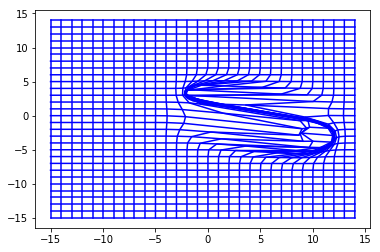

In [16]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation(modules, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)



mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue')
mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue')
plt.show()
